Let's start by importing some important modules.

In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import astropy.units as u
from astropy import constants as const 
from helpers import get_error_spectrum, v_to_wavelen
from spectral_cube import SpectralCube
from astropy.table import Table
from line_detection import detect_lines, detect_lines_from_table
import re

# Spectrum at a Given Pixel
This function returns the spectrum at a given spaxel (x, y) over some wavelength range given by its center and width.

In [2]:
def spec_at_pixel(cube, center, width, x, y):
    '''
    Takes a spectral cube (units uJy) and plots based on wavelength
    at a given center and width, at a given x, y spaxel.
    Also plots error bars if error cube is given.
    '''
    delta = (width / 2)
    subcube = cube.spectral_slab(center-delta, center+delta)
    flux_spec = subcube[:, y, x]  # shape: (n_channels,)
    vcube = subcube.with_spectral_unit(u.km/u.s, velocity_convention='optical',rest_value=center)
    v = vcube.spectral_axis
    
    return v, flux_spec

# Plotting the spectrum

In [3]:
def plot_spec_at_pixel(fits_file, subtracted_cube, center, width, pixel_list, velocity=False, lines=None):
    cube = subtracted_cube
    plt.figure(figsize=(12, 6))

    colors = ['blue', 'teal', 'palevioletred']
    for i, (x, y) in enumerate(pixel_list):
        v, flux = spec_at_pixel(cube, center, width, x, y)
        wavelengths = v_to_wavelen(center, v) # for plotting using wavelength
        error = get_error_spectrum(fits_file, subtracted_cube, x, y)
        label = f"Pixel ({x}, {y})" 
        
        if velocity:
            plt.plot(v, flux, drawstyle='steps-mid', color=colors[i], label=label)
        else:
            plt.plot(wavelengths, flux, drawstyle='steps-mid', color=colors[i], label=label)
        # Error bars
        if error is not None:
            if velocity:
                plt.fill_between(v, (flux - error).value, (flux + error).value, step='mid', alpha=0.4, color=colors[i])
            else:
                plt.fill_between(wavelengths, (flux - error).value, (flux + error).value, step='mid', alpha=0.4, color=colors[i])
    
    if velocity:    
        plt.axvline(0, color='black', linestyle='-',alpha=0.7)
        plt.axhline(0, color='blue', linestyle='--', alpha=0.4)
        plt.xlabel('Velocity (km/s)', fontsize=13)
    else: 
        plt.xlabel('Wavelength (μm)', fontsize=13)
        if lines is not None:
            for wav, flux, _ in lines:
                plt.plot(wav.value, flux.value * 1.3, color='r', marker='|', markersize=6)
                # plt.text(wav.value, 15, f"{wav:.3f}", rotation=90, verticalalignment='top', horizontalalignment='right', fontsize=8, color='gray')

    plt.ylabel('Flux (μJy)', fontsize=13)
    # plt.ylim(-3, 20)
    plt.title(f'Emission Line Profile', fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Saving detected lines to LaTeX

In [4]:
def save_lines_to_latex(lines, database_lines):
    # Define the species patterns, colors, and regexes
    species_info = [
        ("H2", "red", r"(H2[^',]*)"),
        ("Fe I]", "greenyellow", r"(Fe I\][^,]*)"),
        ("[Fe II]", "green", r"(\[Fe II\][^,]*)"),
        ("[Fe III]", "darkseagreen", r"(\[Fe III\][^,]*)"),
        ("H I", "orange", r"(H I[^',]*)"),
        ("He", "purple", r"(He[^',]*)"),  # He I
        ("S I", "teal", r"(He[^',]*)"),
        ("[S III]", "indigo", r"(He[^',]*)"),
        ("O I", "crimson", r"(He[^',]*)"),
        ("[O III]", "deeppink", r"(He[^',]*)")
    ]
    
    # Precompute tables and wavelengths for each species
    species_tables = {}
    for key, color, regex in species_info:
        table = database_lines[[key in s for s in database_lines['species_list']]]
        species_tables[key] = {
            "table": table,
            "wavelengths": table['rest_wavelength'],
            "color": color,
            "regex": regex
        }

    # Initialize tables for each species (will store matched lines)
    matched_tables = {}

    # Try to match each detected line with a reference line
    for wav, fluxes, snr in lines:
        for key, info in species_tables.items():
            mask = np.abs(info["wavelengths"] - wav) <= 0.001

            if np.any(mask):
                masked_wavs = info["table"]['rest_wavelength'][mask]

                # Makes sure for this species that there are no dupes
                assert(len(masked_wavs) == 1)
                
                db_wav = masked_wavs[0]
                                
                transition_label = info["table"]['transition_labels'][mask]
                label_str = str(*transition_label)
                
                match = re.search(info["regex"], label_str)
                assert(match)
                
                line_info = {'wav_db': db_wav, 'flux': fluxes, 'transition_label': match.group(1)}
                matched_tables.setdefault(key, []).append(line_info) # setdefault makes the key with [] if not in the dict yet
                
                # Search for H2 0-0 transitions for rotational diagram
                # match = re.search(r"v=0-0", label_str)
                # if match:
                #     print(fluxes, label_str)
                
                break            
        
        
        
    matched_tables = {k: Table(rows=v) for k, v in matched_tables.items() if v}
    
    for key in matched_tables:
        table = matched_tables[key]

        # Export to LaTeX 
        df = table.to_pandas()
        
        if key == "[Fe II]":
            closest_row = df.iloc[(df['wav_db'] - 1.644).abs().argmin()]
            flux_1644 = closest_row['flux']
            df['flux'] = df['flux'] / flux_1644
            df = df.rename(columns={'flux': '$F_{line}/F_{1.644}$'}) # \\ so Python reads as \
                
        elif key == "H2":
            closest_row = df.iloc[(df['wav_db'] - 2.122).abs().argmin()]
            flux_2122 = closest_row['flux']
            df['flux'] = df['flux'] / flux_2122
            df = df.rename(columns={'flux': '$F_{line}/F_{2.122}$'})
            
        else:
            df = df.rename(columns={"flux": 'Flux ($\\mu$Jy)'})
            
        # rename the other two columns
        df = df.rename(columns={
            "wav_db": "$\\lambda$ ($\\mu$m)", 
            "transition_label": "Transition"
        })
        
        latex_str = df.to_latex(
                    index=False,  # To not include the DataFrame index as a column in the table
                    caption=f"Detected {key} Lines",  # The caption to appear above the table in the LaTeX document
                    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
                    column_format="lccc",  # The format of the columns: left-aligend first column and center-aligned remaining columns as per APA guidelines
                    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
                    float_format="{:0.4f}".format  # Formats floats to two decimal places
                    )
        
        # Takes it out of table, removes caption and last line
        latex_lines = latex_str.splitlines()
        filtered_lines = [line for line in latex_lines if not (
            line.startswith('\\begin{table}') or 
            line.startswith('\\end{table}') or 
            line.startswith('\\caption') or
            line.startswith('\\end{tabular}')
        )]

        # Add \centering before closing table
        filtered_lines.append(r"\centering")
        filtered_lines.append(r"\end{tabular}")

        # Join back to string
        final_latex = "\n".join(filtered_lines) + "\n"
        
        with open(f"../Line Tables/lines_table_{key}.tex", "w") as f:
            f.write(final_latex)

        print(f"Saved as lines_table_{key}.tex")
    
    detected = 0
    dupes = 0
    for wav in database_lines['rest_wavelength']:
        if np.any(np.abs(lines['wavelength'] - wav) <= 0.001):
            # print(f'{wav:.5f} detected')
            detected += 1
            # counts duplicates
            if np.sum(np.abs(lines['wavelength'] - wav) <= 0.001) > 1:
                dupes += 1
                # print(f'{wav:.5f} has duplicates')
        else:
            pass 
            # print(f'{wav:.5f} not detected')
    print(f'total detected: {detected}')
    print(f'total undetected: {len(database_lines) - detected}')
    print(f'total dupes: {dupes}')

# Plot Spec

In [5]:
def plot_spec(wavelengths, flux, error=None, x=None, y=None, lines=None, database_lines=None):
    '''
    Plots spectrum given arrays of wavelength, flux, and error (optional)
    Can indicate given lines and color them based on lines_dict
    '''       
    fig, ax = plt.subplots(figsize=(12, 6))
    label = f"Pixel ({x}, {y})" 

    ax.plot(wavelengths, flux, drawstyle='steps-mid', color='blue', label=label)
    # Error bars
    if error is not None:
        ax.fill_between(wavelengths, (flux - error).value, (flux + error).value, step='mid', alpha=0.4, color='blue')
    
        if lines is not None and database_lines is not None:
            # Define the species patterns, colors, and regexes
            species_info = [
                ("H2", "red", r"(H2[^',]*)"),
                ("Fe I]", "greenyellow", r"(Fe I\][^,]*)"),
                ("[Fe II]", "green", r"(\[Fe II\][^,]*)"),
                ("[Fe III]", "darkseagreen", r"(\[Fe III\][^,]*)"),
                ("H I", "orange", r"(H I[^',]*)"),
                ("He", "purple", r"(He[^',]*)"),  # He I
                ("S I", "teal", r"(He[^',]*)"),
                ("[S III]", "indigo", r"(He[^',]*)"),
                ("O I", "crimson", r"(He[^',]*)"),
                ("[O III]", "deeppink", r"(He[^',]*)")
            ]
            
            # Precompute tables and wavelengths for each species
            species_tables = {}
            for key, color, regex in species_info:
                table = database_lines[[key in s for s in database_lines['species_list']]]
                species_tables[key] = {
                    "table": table,
                    "wavelengths": table['rest_wavelength'],
                    "color": color,
                    "regex": regex
                }

            # Try to match each detected line with a reference line
            for wav, fluxes, snr in lines:
                matched = False
                for key, info in species_tables.items():
                    mask = np.abs(info["wavelengths"] - wav) <= 0.001
    
                    if np.any(mask):
                        masked_wavs = info["table"]['rest_wavelength'][mask]

                        # Makes sure for this species that there are no dupes
                        assert(len(masked_wavs) == 1)
                        
                        db_wav = masked_wavs[0]
                        
                        ax.plot(wav, fluxes + fluxes / snr + 1, color=info["color"], marker='v', markersize=4)
                        
                        transition_label = info["table"]['transition_labels'][mask]
                        label_str = str(*transition_label)
                        
                        match = re.search(info["regex"], label_str)
                        assert(match)
                        ax.text(wav, fluxes + fluxes / snr + 2, f"{wav:.3f}, " + match.group(1),
                                rotation=90, va='bottom', ha='center', fontsize=8, color='black')
                        
                        matched = True
                        break
                
                # Plot all other lines
                if not matched:
                    ax.plot(wav, fluxes + fluxes / snr + 1, color='black', marker='v', markersize=2)
            
            # Prints database values not detected
            detected = 0
            dupes = 0
            for wav in database_lines['rest_wavelength']:
                if np.any(np.abs(lines['wavelength'] - wav) <= 0.001):
                    # print(f'{wav:.5f} detected')
                    detected += 1
                    # counts duplicates
                    if np.sum(np.abs(lines['wavelength'] - wav) <= 0.001) > 1:
                        dupes += 1
                        # print(f'{wav:.5f} has duplicates')
                else:
                    pass 
                    # print(f'{wav:.5f} not detected')
            print(f'total detected: {detected}')
            print(f'total undetected: {len(database_lines) - detected}')
            print(f'total dupes: {dupes}')
    
    plt.xlabel('Wavelength (μm)', fontsize=13)
    plt.ylabel('Flux (μJy)', fontsize=13)
    # plt.ylim(-3, 20)
    plt.title(f'Emission Line Profile', fontsize=15)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


Available spaxels:
- (23, 26) - Approx star location
- (25, 34) - Brightest atomic jet knot
- (35, 41) - Brightest H2 lobe
    
Peak brightnesses: [(25.26613227, 33.59679364), (26.13168151, 38.79008904), (27.0120717, 44.07243022)] 

Molecular ring lobes: [(35, 41), (21, 46), (24, 35)]

total detected: 102
total undetected: 718
total dupes: 0


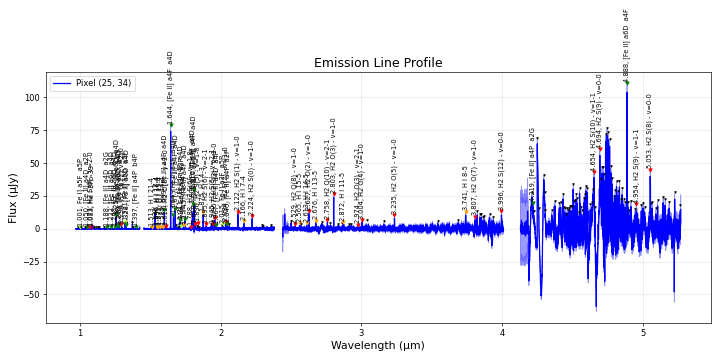

In [8]:
pixels = [(25, 34)]
table = Table.read(f'../fits/merged_spectrum{pixels[0][0]}_{pixels[0][1]}.fits')
detected_lines = Table.read(f'../fits/detected_lines{pixels[0][0]}_{pixels[0][1]}.fits')
database_table = Table.read('../fits/grouped_lines_summary.fits')

plt.rcParams['figure.dpi'] = 60 # Changes widget size
plot_spec(table['wavelength'], table['flux'], table['error'], pixels[0][0], pixels[0][1], detected_lines, database_table)
# save_lines_to_latex(detected_lines, database_table)

In [7]:
'''
=== Code for plotting spectrum of entire fits file ===
fits_file = 'fits/4s3d.fits'
subtracted_cube = SpectralCube.read('fits/subtracted_cube_full4.fits')

for lam, flux, snr_val in lines:
    print(f"Wavelength: {lam:.4f}, SNR: {snr_val:.2f}")

print(f"Line count: {len(lines)}")

if fits_file == 'fits/4s3d.fits':
    plot_spec_at_pixel(fits_file, subtracted_cube, 1.4*u.um, 1*u.um, pixels, False, lines)
elif fits_file == 'fits/5s3d.fits':
    plot_spec_at_pixel(fits_file, subtracted_cube, 2.42*u.um, 1.6*u.um, pixels, False, lines)
elif fits_file == 'fits/6s3d.fits':
    plot_spec_at_pixel(fits_file, subtracted_cube, 4*u.um, 2.3*u.um, pixels, False, lines)

Use 24, 28 for Fe II; 32, 42 for H2
'''

'\n=== Code for plotting spectrum of entire fits file ===\nfits_file = \'fits/4s3d.fits\'\nsubtracted_cube = SpectralCube.read(\'fits/subtracted_cube_full4.fits\')\n\nfor lam, flux, snr_val in lines:\n    print(f"Wavelength: {lam:.4f}, SNR: {snr_val:.2f}")\n\nprint(f"Line count: {len(lines)}")\n\nif fits_file == \'fits/4s3d.fits\':\n    plot_spec_at_pixel(fits_file, subtracted_cube, 1.4*u.um, 1*u.um, pixels, False, lines)\nelif fits_file == \'fits/5s3d.fits\':\n    plot_spec_at_pixel(fits_file, subtracted_cube, 2.42*u.um, 1.6*u.um, pixels, False, lines)\nelif fits_file == \'fits/6s3d.fits\':\n    plot_spec_at_pixel(fits_file, subtracted_cube, 4*u.um, 2.3*u.um, pixels, False, lines)\n\nUse 24, 28 for Fe II; 32, 42 for H2\n'